# [Module 5] 예측 결과 분석 하기 (Analyze a Target Forecast)
- 이 노트북은 얼마나 예측이 잘 되었는지를 모듈 1에서 생성한 검증셋과 비교를 하여 정확도를 계산 합니다. 또한 Prophet, DeepAR+ 의 두개 정확도의 비교를 합니다.

* **About 10 mins may be elapsed**

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
# 다른 노트북에서 저장된 변수들을 불러옴
%store -r
# target_prophet_predictorArn
# target_deepar_predictorArn


In [3]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

## Obtaining the forecast results from S3
- 아래의 작업은 S3에 저장된 예측 결과를 이 노트북 인스턴스에 다운로드 하는 과정 입니다. 로컬에 폴더를 만들고 다운로드 후에 폴더는 다시 삭제 합니다.

In [4]:
import os
prophet_result_dir = "prophet" + suffix
deepar_result_dir = "deeparp" + suffix
! mkdir -p {prophet_result_dir} # Create a folder for prophet forecast result
! mkdir -p {deepar_result_dir}

In [5]:
# Prophet
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prefix = bucket_folder + "/" +  "prophet_" + target_suffix + suffix
prophet_filename = ""
# print("prefix: ", prefix)
prophet_files = list(poc_bucket.objects.filter(Prefix=prefix))
# print("prophet_files: ", prophet_files)
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[2]
        s3.Bucket(bucket_name).download_file(file.key, prophet_result_dir+"/"+prophet_filename)


In [6]:
# DeepAR+
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prefix = bucket_folder + "/" + "deeparp_" + target_suffix + suffix
deeparp_filename = ""
deeparp_files = list(poc_bucket.objects.filter(Prefix=prefix))
# print(deeparp_files)
# print(deeparp_files)
for file in deeparp_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deeparp_filename = file.key.split('/')[2]
        s3.Bucket(bucket_name).download_file(file.key, deepar_result_dir+"/"+deeparp_filename)
# print(deeparp_filename)

In [7]:
def getTotalForecastResult(resultFolder):
    """
    Return a dataframe containing all forecast files in the folder passed
    """
    total_predicts_s3 = pd.DataFrame()
    for file in os.listdir(resultFolder):
        predicts_s3 = pd.read_csv(resultFolder + "/" + file)
        total_predicts_s3 = total_predicts_s3.append(predicts_s3)
    return total_predicts_s3
    
prophet_predicts_s3 = getTotalForecastResult(prophet_result_dir)    
deeparp_predicts_s3 = getTotalForecastResult(deepar_result_dir)    


In [8]:
# Remove the folders already used
! rm -rf {prophet_result_dir}
! rm -rf {deepar_result_dir}

## Load forecast results from local folder 
- 두 개의 데이타 프레임에 저장된 컬럼 정보를 확인 합니다.

In [9]:
prophet_predicts_s3.info()
deeparp_predicts_s3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15500 entries, 0 to 743
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  15500 non-null  int64  
 1   date     15500 non-null  object 
 2   store    15500 non-null  int64  
 3   p10      15500 non-null  float64
 4   p50      15500 non-null  float64
 5   p90      15500 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 847.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15500 entries, 0 to 495
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  15500 non-null  int64  
 1   date     15500 non-null  object 
 2   store    15500 non-null  int64  
 3   p10      15500 non-null  float64
 4   p50      15500 non-null  float64
 5   p90      15500 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 847.7+ KB


## Prophet 예측 결과

- 아래 데이타의 해석의 방법은 첫번째 Row의 경우에 item_id 11이 2017년 12월 1일에 Store3에서 p10 기준으로 약 74개가 팔리고, p50 기준으로 약 89가 팔리고, p90 기준으로 약 101개가 팔릴 것으로 예측을 하였습니다.

In [10]:
prophet_predicts = prophet_predicts_s3.copy()
prophet_predicts.head()


,item_id,date,store,p10,p50,p90
0,11,2017-12-01T00:00:00Z,3,74.894855,89.089977,101.274323
1,11,2017-12-02T00:00:00Z,3,78.449907,89.979012,101.141700
2,11,2017-12-03T00:00:00Z,3,83.553846,96.038843,108.402696
3,11,2017-12-04T00:00:00Z,3,47.282416,59.095725,72.153780
4,11,2017-12-05T00:00:00Z,3,56.542317,69.210028,79.547692


### 아래는 실제 Actual 값 (validation_time_series.csv) 과 비교를 위해서 포맷을 바꾸는 작업을 합니다.

In [11]:
# Remove the timezone
prophet_predicts = prophet_predicts_s3.copy()
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date']) # + pd.DateOffset(days=4)
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None) # Convert time zone
prophet_predicts.date = pd.to_datetime(prophet_predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
prophet_predicts.item_id = prophet_predicts.item_id.astype(str) # convert to string type
prophet_predicts.store = prophet_predicts.store.astype(str) # convert to string type
prophet_predicts = prophet_predicts[['date','item_id','store','p10', 'p50', 'p90']]

prophet_predicts.head()

,date,item_id,store,p10,p50,p90
0,2017-12-01,11,3,74.894855,89.089977,101.274323
1,2017-12-02,11,3,78.449907,89.979012,101.141700
2,2017-12-03,11,3,83.553846,96.038843,108.402696
3,2017-12-04,11,3,47.282416,59.095725,72.153780
4,2017-12-05,11,3,56.542317,69.210028,79.547692


In [12]:
# Remove the timezone
deeparp_predicts = deeparp_predicts_s3.copy()
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date']) # + pd.DateOffset(days=4)
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None) # Convert time zone
deeparp_predicts.date = pd.to_datetime(deeparp_predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
deeparp_predicts.item_id = deeparp_predicts.item_id.astype(str) # convert to string type
deeparp_predicts.store = deeparp_predicts.store.astype(str) # convert to string type
deeparp_predicts = deeparp_predicts[['date','item_id','store','p10', 'p50', 'p90']]
# deeparp_predicts = deeparp_predicts[deeparp_predicts.item_id == "1"] # only for itme_id == 1
deeparp_predicts.head()
# prophet_predicts.dtypes

,date,item_id,store,p10,p50,p90
0,2017-12-01,20,9,41.211132,51.109184,66.872475
1,2017-12-02,20,9,42.319824,52.349026,63.862137
2,2017-12-03,20,9,41.865208,53.039520,63.667576
3,2017-12-04,20,9,21.473801,32.111420,40.768944
4,2017-12-05,20,9,29.059822,39.443325,51.730000


## Prepare validation file
- Module 1에서 준비한 검증 데이타 셋 (2017년 12월 데이터)를 가져옵니다.

In [13]:
validation_df = validation_stores_sales.copy()
validation_df.reset_index(inplace=True) # reset index
validation_df = validation_df.rename(columns={'index':'date'}) # Change column name to date
validation_df.date = pd.to_datetime(validation_df.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
validation_df.head()
# validation_df.dtypes


,date,item_id,store,sales
0,2017-12-01,1,1,19
1,2017-12-02,1,1,16
2,2017-12-03,1,1,31
3,2017-12-04,1,1,7
4,2017-12-05,1,1,20


## Join forecast results with validation data
- 실제로 예측된 결과 (Prophet) 와 검증 셋 데이타를 조인해서, 한개의 데이타 프레임으로 보이게 합니다. 여기서 실제로 얼마나 잘 예측을 했는지를 눈으로 확인할 수 있습니다.

In [14]:
# Prophet
prophet_val_df = pd.merge(prophet_predicts,validation_df, 
                          on=['date', 'item_id','store'], 
                          how='inner')
                          
prophet_val_df.set_index('date', inplace=True)
prophet_val_df.head(10)

,item_id,store,p10,p50,p90,sales
date,,,,,,
2017-12-01,11,3,74.894855,89.089977,101.274323,75
2017-12-02,11,3,78.449907,89.979012,101.141700,72
2017-12-03,11,3,83.553846,96.038843,108.402696,63
2017-12-04,11,3,47.282416,59.095725,72.153780,49
2017-12-05,11,3,56.542317,69.210028,79.547692,58
2017-12-06,11,3,58.635529,70.610955,83.008054,54
2017-12-07,11,3,63.161191,73.043955,85.917415,60
2017-12-08,11,3,67.259871,78.320802,91.892873,66
2017-12-09,11,3,72.496599,82.480841,92.952724,79


- 같은 작업을 DeepAR+ 에서도 합니다.

In [15]:
# deeparp
deeparp_val_df = pd.merge(deeparp_predicts,validation_df, 
                          on=['date', 'item_id','store'], 
                          how='inner')
                          
deeparp_val_df.set_index('date', inplace=True)
deeparp_val_df.head(10)
# deeparp_val_df[deeparp_val_df.item_id == "1"].head()

,item_id,store,p10,p50,p90,sales
date,,,,,,
2017-12-01,20,9,41.211132,51.109184,66.872475,48
2017-12-02,20,9,42.319824,52.349026,63.862137,40
2017-12-03,20,9,41.865208,53.039520,63.667576,55
2017-12-04,20,9,21.473801,32.111420,40.768944,36
2017-12-05,20,9,29.059822,39.443325,51.730000,31
2017-12-06,20,9,31.690933,40.672165,51.108841,42
2017-12-07,20,9,35.395084,41.682465,53.547783,49
2017-12-08,20,9,34.971237,46.073250,56.686653,42
2017-12-09,20,9,39.022457,49.979790,58.543739,47


## MAPE metric for Prophet and DeepARP
- MAPE 는 에러 지표의 하나로서, 아래 mape_p50이 0.18이면 정확도는 1-0.18 = 0.82로서 약 82%의 정확도를 보임.

In [16]:
prophet_val_metric_df = prophet_val_df.copy()
n_rows = prophet_val_metric_df.shape[0]
prophet_val_metric_df['mape_p50'] = (abs(prophet_val_metric_df.sales - prophet_val_metric_df.p50) / prophet_val_metric_df.sales ) 
# prophet_val_metric_df.head(200)
print("prophet MAPE: ", prophet_val_metric_df['mape_p50'].mean())
prophet_val_metric_df.head(4)


prophet MAPE:  0.17095377382133173


,item_id,store,p10,p50,p90,sales,mape_p50
date,,,,,,,
2017-12-01,11,3,74.894855,89.089977,101.274323,75,0.187866
2017-12-02,11,3,78.449907,89.979012,101.141700,72,0.249709
2017-12-03,11,3,83.553846,96.038843,108.402696,63,0.524426
2017-12-04,11,3,47.282416,59.095725,72.153780,49,0.206035


In [17]:
deeparp_val_metric_df = deeparp_val_df.copy()
n_rows = deeparp_val_metric_df.shape[0]
deeparp_val_metric_df['mape_p50'] = (abs(deeparp_val_metric_df.sales - deeparp_val_metric_df.p50) / deeparp_val_metric_df.sales ) 
# prophet_val_metric_df.head(200)
print("deeparp: ", deeparp_val_metric_df['mape_p50'].mean())
deeparp_val_metric_df.head(4)

deeparp:  0.14690541040378305


,item_id,store,p10,p50,p90,sales,mape_p50
date,,,,,,,
2017-12-01,20,9,41.211132,51.109184,66.872475,48,0.064775
2017-12-02,20,9,42.319824,52.349026,63.862137,40,0.308726
2017-12-03,20,9,41.865208,53.039520,63.667576,55,0.035645
2017-12-04,20,9,21.473801,32.111420,40.768944,36,0.108016


## An example of single forecast with Item_id and Store
- item_id , Store의 두개의 조합으로 12/29 - 12/31 의 예측 데이타를 볼 수 있는 예제 입니다.

In [18]:
forecast_query_response = forecast_query.query_forecast(
    ForecastArn = target_prophet_forecast_arn,
    StartDate = "2017-12-29T00:00:00",
    EndDate = "2017-12-31T00:00:00",
    Filters={"item_id": "1", "store":"1"}
)
forecast_query_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2017-12-29T00:00:00',
     'Value': 11.287120819091797},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 13.533132553100586},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 14.087742805480957}],
   'p50': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 17.56049346923828},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 19.81742286682129},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 20.053247451782227}],
   'p90': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 21.85826873779297},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 25.305843353271484},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 27.8986873626709}]}},
 'ResponseMetadata': {'RequestId': 'f0485c29-7ac7-4ac6-bb3d-034adac61e64',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 02 Jul 2020 08:09:42 GMT',
   'x-amzn-requestid': 'f0485c29-7ac7-4ac6-bb3d-034adac61e64',
   'content-length': '616',
   'conne

## An example of single forecast with Item_id
- item_id 만을 가지고 예측 결과를 가져오기에 모든 Store의 전체 합산 예측값을 가져 옵니다.

In [19]:

forecast_query_response = forecast_query.query_forecast(
    ForecastArn = target_prophet_forecast_arn,
    StartDate = "2017-12-29T00:00:00",
    EndDate = "2017-12-31T00:00:00",
    Filters={"item_id":"1"}
)

forecast_query_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2017-12-29T00:00:00',
     'Value': 143.8965196609497},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 160.39077758789062},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 169.79105186462402}],
   'p50': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 204.76787853240967},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 218.83885383605957},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 230.78377151489258}],
   'p90': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 261.57579612731934},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 281.2198181152344},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 295.0338363647461}]}},
 'ResponseMetadata': {'RequestId': 'd8cd6a74-ddc4-44a9-9f98-535010b22d4e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 02 Jul 2020 08:09:44 GMT',
   'x-amzn-requestid': 'd8cd6a74-ddc4-44a9-9f98-535010b22d4e',
   'content-length': '618',
   'con

## Analyse prophet and deepar+ for some stores
- 아래는 Prophet, DeepAR+의 두개의 예측 결과 및 실제 값을 그래프로 그려서 시각화를 합니다.

In [20]:
from utils import show_two_chart_horizontal

In [21]:
deeparp_val_df.item_id.unique()
# prophet_val_df.item_id.unique()
deeparp_val_df.store.unique()

array(['9', '6', '8', '10', '2', '4', '5', '1', '7', '3'], dtype=object)

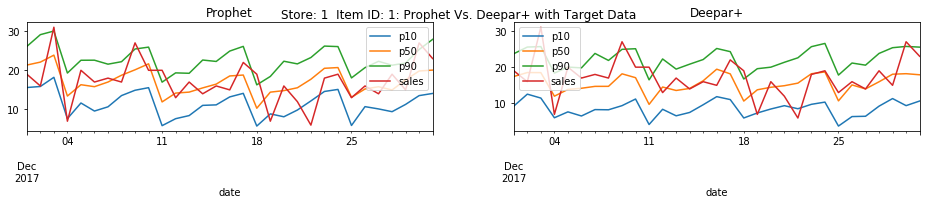

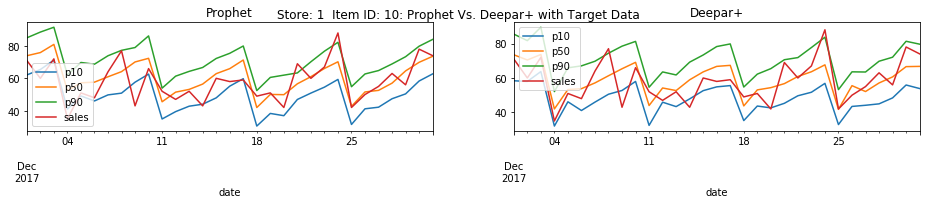

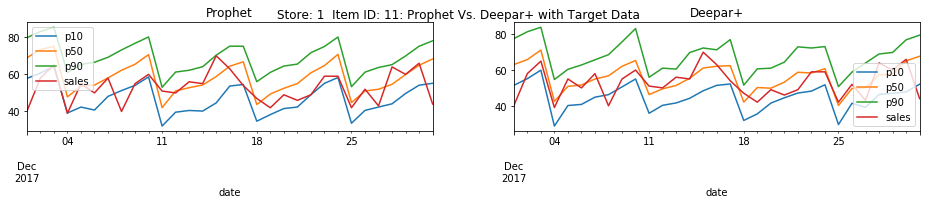

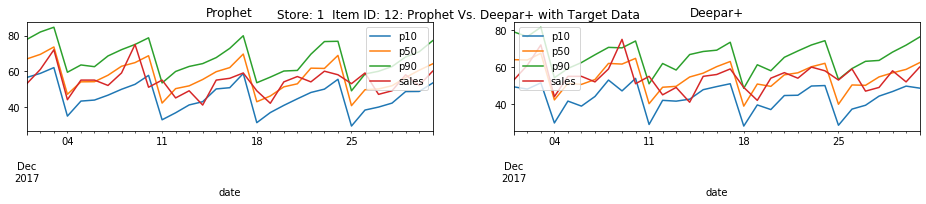

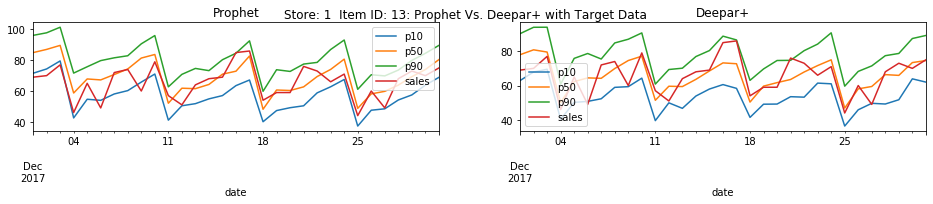

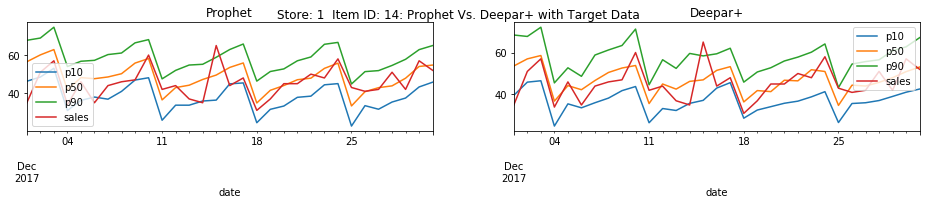

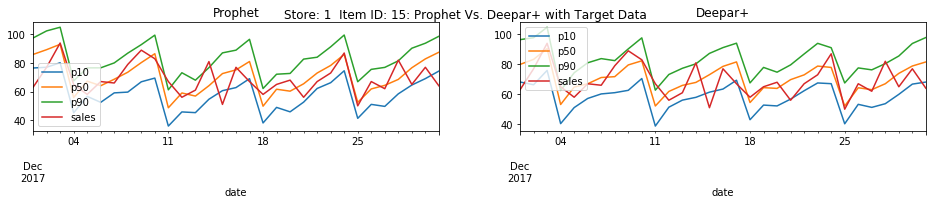

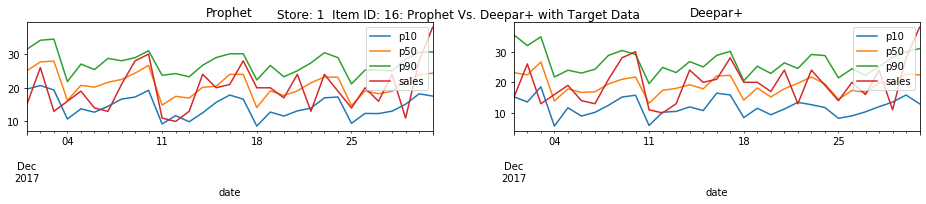

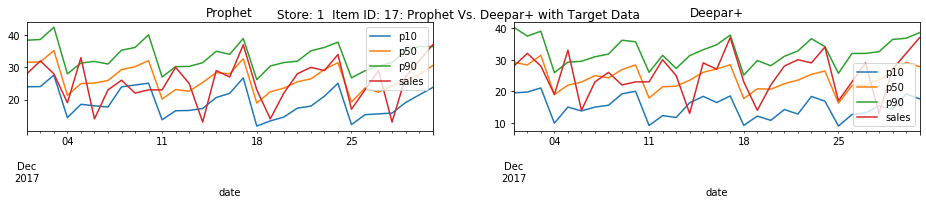

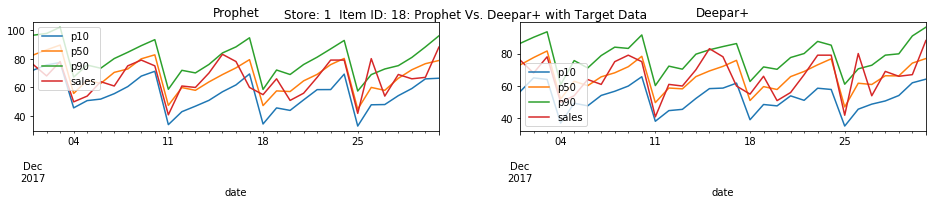

In [22]:
store_item_df = pd.DataFrame(deeparp_val_df.groupby(['store','item_id']).count())
store_item_df = store_item_df.reset_index()


display_num = 10
for i, rows in store_item_df.iterrows():
    store_id = rows['store']
    item_id = rows['item_id']    
    if display_num == i:
        break
    filter_prophet = (prophet_val_df.item_id == str(item_id)) & (prophet_val_df.store == str(store_id))
    filter_deeparp = (deeparp_val_df.item_id == str(item_id)) & (deeparp_val_df.store == str(store_id))
    
    prophet_val_single_df = prophet_val_df[filter_prophet]
    deeparp_val_single_df = deeparp_val_df[filter_deeparp]    
    plot_title = "Store: " + str(store_id) + "  Item ID: " + str(item_id) + ": Prophet Vs. Deepar+ with Target Data"
    show_two_chart_horizontal(plot_title, 
                          prophet_val_single_df, 
                          "Prophet", 
                          deeparp_val_single_df,
                          "Deepar+", 
                         )
        